In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from models_gaussian import StandardGaussianHMM, GaussianDenseHMM
import time
from tqdm import tqdm
from ssm.util import find_permutation   # finds the best permutation to match the states
import warnings

# warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(2022)

2022-08-03 15:52:21.694084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 15:52:21.694109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def prepare_params(n):  # Does not hold the assumption: pi stationar of A
    pi = np.random.uniform(size=n)
    pi /= pi.sum()

    A = np.exp(np.random.uniform(0, 5, size=(n, n)))
    A +=  np.diag([5 for _ in range(n)])
    A /= A.sum(axis=1)[:, np.newaxis]

    # TODO:  you can change the difficuly of an example by changing the ranges for mu and sigma
    mu = np.random.uniform(-20, 20, size=n)  # bigger range - easier task
    sigma = np.random.uniform(0.1,  1.0, size=n)  # smaller range -  easier task
    return pi, A, mu, sigma


def my_hmm_sampler(pi, A,  mu, sigma, T):  # TODO
    n = pi.shape[0]
    X = [np.random.choice(np.arange(n), 1, replace=True, p=pi)]
    for t in range(T - 1):
        X.append(np.random.choice(np.arange(n), 1, replace=True, p=A[X[t][0], :]))
    Y = np.concatenate([np.random.normal(mu[s[0]], sigma[s[0]], 1) for s in X]).reshape(-1, 1)
    return X, Y

def prepare_data(pi, A,  mu, sigma, T, s):
    data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
    X_true = np.concatenate([np.concatenate(y[0]) for y in data])
    Y_true = np.concatenate([x[1] for x in data])
    lengths = [len(x[1]) for x in data]
    return X_true, Y_true, lengths  # hidden states, observations, lengths of individual sequences

def dtv(a1, a2):
    return (abs(a1 - a2) / 2).sum() / a1.shape[0]

Initial distribution:  
 [0.01505084 0.80260167 0.18234749]
Transition matrix: 
 [[0.12960601 0.6349542  0.2354398 ]
 [0.427543   0.14639522 0.42606178]
 [0.21864572 0.37938259 0.40197168]]
Distributions of outputs: 
 - N(mu=13.343, sigma=0.545)
 - N(mu=18.282, sigma=0.406)
 - N(mu=-5.278, sigma=0.657)


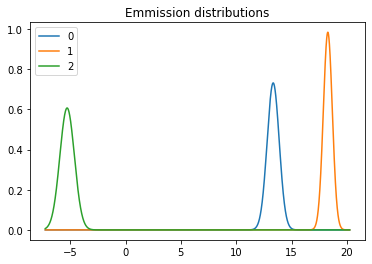

In [3]:
n = 3  # TODO:  define number of hidden states
pi, A, mu, sigma = prepare_params(n)

print("Initial distribution:  \n", pi)
print("Transition matrix: \n",  A)
print("Distributions of outputs: \n", "\n ".join([f"- N(mu={round(m, 3)}, sigma={round(sig, 3)})" for m, sig in zip(mu, sigma)]))

x = np.linspace(min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma), 10000)
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]), label=str(i))
plt.title("Emmission distributions")
plt.legend()
plt.show()

In [4]:
s = 44  # TODO: define number of observed  sequences
T = 72  # TODO:  define length of observed seqences

X_true, Y_true, lengths = prepare_data(pi, A,  mu, sigma, T, s)

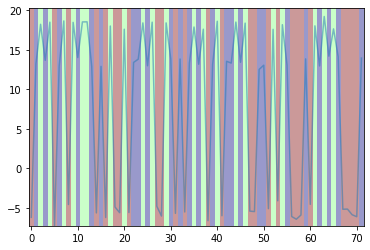

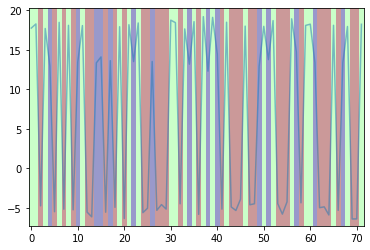

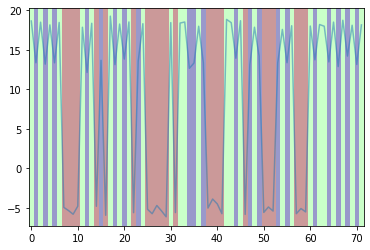

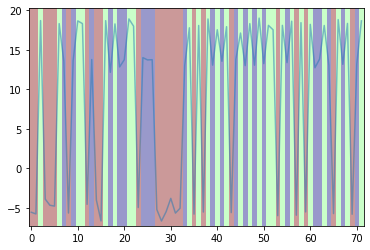

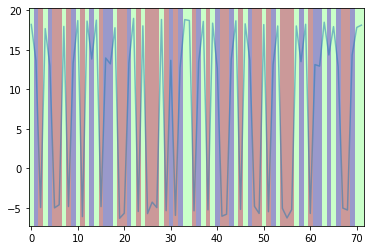

In [5]:
plot_all_sequences = False  #  Plot all  (or 5)  sequences

for i in range(s if plot_all_sequences else  5):
    i1 = sum(lengths[:i])
    i2 = sum(lengths[:(i+1)])
    plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, min(mu) - 3 * max(sigma), max(mu) + 3*max(sigma)), cmap="jet", alpha=0.4)
    plt.plot(Y_true[i1:i2], alpha=.5)
    plt.show()

#  Standard HMM

In [6]:
# # fit standard HMM - custom implementation
#
# standardhmm = StandardGaussianHMM(n, em_iter=2, covariance_type='diag')
#
# start = time.perf_counter()
# standardhmm.fit(Y_true, lengths)
# print("Standard HMM learning time:", round(time.perf_counter() - start, 3))
#
# preds = np.concatenate([standardhmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
# perm = find_permutation(preds, X_true)
# preds_perm = np.array([perm[i] for i in preds])
# print("Standard HMM accuracy: ", round((X_true == preds_perm).mean(),  3))
#
# # TODO:  permute metrices
# print("d_tv for initial probability:", round(dtv(standardhmm.startprob_.reshape(1, -1), pi[perm].reshape(1, -1)),  3))
# print("d_tv for transition probability:", round(dtv(standardhmm.transmat_, A[perm, :][:, perm]),  3))
# print("MAE for mus:", round(abs(mu[perm] - standardhmm.means_[:, 0]).mean(),  3))
# print("MAE for sigmas:", round(abs(sigma[perm] - standardhmm.covars_[:, 0, 0]).mean(),  3))

In [7]:
# for i in range(s if plot_all_sequences else  5):
#     i1 = sum(lengths[:i])
#     i2 = sum(lengths[:(i+1)])
#     lim_bottom = min(mu) - 3 * max(sigma)
#     lim_semi = (min(mu) + max(mu)) / 2
#     lim_upper = max(mu) + 3*max(sigma)
#     plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_bottom, lim_semi), cmap="jet", alpha=0.4)
#     plt.imshow(preds_perm[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_semi, lim_upper), cmap="jet", alpha=0.4)
#     plt.yticks([(lim_bottom + lim_semi) / 2, (lim_semi + lim_upper) / 2],  ["True", "Pred"])
#     plt.plot(Y_true[i1:i2], alpha=.5)
#     plt.show()

In [8]:
# standardhmm.covars_.shape  # (3, 1, 1)
# standardhmm._covars_.shape  # (3, 1)


# Dense HMM

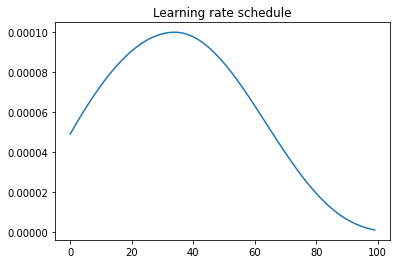

In [9]:
EM_ITER=100
def em_scheduler(max_lr, it):
    if it <= np.ceil(EM_ITER / 3):
        return max_lr * np.cos(3 * (np.ceil(EM_ITER / 3) - it) * np.pi * .33 / EM_ITER)
    else:
        return max_lr * np.cos((it - np.ceil(EM_ITER / 3)) * np.pi * .66 / EM_ITER) ** 3

plt.plot([em_scheduler(.0001, it) for it in range(EM_ITER)])
plt.title("Learning rate schedule")
plt.show()

In [10]:
# # fit dense HMM - custom implementation
# def em_scheduler(max_lr, it):
#     if it <= 34:
#         return max_lr * np.cos(3 * (34 - it) * np.pi * .66 / 200)
#     else:
#         return max_lr * np.cos((it - 34) * np.pi * .66 / 100)
#
# plt.plot([em_scheduler(1, it) for it in range(100)])
# plt.title("Learning rate schedule")
# plt.show()
#
# l_uz = 2  # TODO: specify length of the embedings
#
# # TODO: play with mstep_config parameters
# # You may like to use early stopping and specify convergence_tol
# densehmm = GaussianDenseHMM(n, em_iter=2, covariance_type='diag', mstep_config={"em_lr": 0.001, "em_epochs": 15, 'l_uz': l_uz, "em_scheduler": em_scheduler},
#                             early_stopping=True, convergence_tol=5e-4, init_params="", opt_schemes={"em"})
#
# start = time.perf_counter()
# densehmm.fit(Y_true, lengths)
# print("Dense HMM learning time:", round(time.perf_counter() - start, 3))
#
# preds_d = np.concatenate([densehmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
# perm_d = find_permutation(preds_d, X_true)
# preds_perm_d = np.array([perm_d[i] for i in preds_d])
# print("Dense HMM accuracy: ", round((X_true == preds_perm_d).mean(),  3))
#
# print("d_tv for initial probability:", round(dtv(densehmm.startprob_.reshape(1, -1), pi[perm_d].reshape(1, -1)),  3))
# print("d_tv for transition probability:", round(dtv(densehmm.transmat_, A[perm_d, :][:, perm_d]),  3))
# print("MAE for mus:", round(abs(mu[perm_d] - densehmm.means_[:, 0]).mean(),  3))
# print("MAE for sigmas:", round(abs(sigma[perm_d] - densehmm.covars_[:, 0, 0]).mean(),  3))
#
# # ValueError: array must not contain infs or NaNs - probably means that one state has been dropped, to be handled

In [11]:
# for i in range(s if plot_all_sequences else  5):
#     i1 = sum(lengths[:i])
#     i2 = sum(lengths[:(i+1)])
#     lim_bottom = min(mu) - 3 * max(sigma)
#     lim_semi = (min(mu) + max(mu)) / 2
#     lim_upper = max(mu) + 3*max(sigma)
#     plt.imshow(X_true[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_bottom, lim_semi), cmap="jet", alpha=0.4)
#     plt.imshow(preds_perm_d[i1:i2].reshape(1, -1), aspect="auto", extent = (-.5, T-.5, lim_semi, lim_upper), cmap="jet", alpha=0.4)
#     plt.yticks([(lim_bottom + lim_semi) / 2, (lim_semi + lim_upper) / 2],  ["True", "Pred"])
#     plt.plot(Y_true[i1:i2], alpha=.5)
#     plt.show()

In [12]:
# densehmm.covars_.shape  # (3, 1, 1)
# densehmm._covars_.shape  # (3, 1)


## Dense HMM Co-occurrences

In [13]:
# with densehmm.session.as_default():
#     print(densehmm.A_from_reps_hmmlearn.eval())
# # self.A_stationary
# from utils import compute_stationary
# A, B = self.session.run([self.A_from_reps_hmmlearn, self.B_from_reps_hmmlearn])
# compute_stationary(A, verbose=False)

In [14]:
# def _to_disrete(X):
#     nodes = self._provide_nodes(X).reshape(tuple([1 for _ in range(len(X.shape))] + [-1]))
#     return (X < nodes).sum(axis=-1)

In [15]:
# # B_scalars_tmp[:, 1:] - B_scalars_tmp[:, :100]
# # with densehmm.session.as_default():
# #     print(densehmm.z.eval())
#
# # densehmm.init_ = densehmm.initializer
# # densehmm.fit_coocs(Y_true, lengths)
# from utils import  empirical_coocs
# gt_AB=None
# self = densehmm
# X = Y_true
# X, n_seqs, max_seqlen = self._init(X, lengths)
# val_lengths=None
# gt_omega = None
# freqs, gt_omega_emp = empirical_coocs(self._to_disrete(X) - 1, self.discrete_observables, lengths=lengths)
# gt_omega_emp = np.reshape(gt_omega_emp, newshape=(self.discrete_observables, self.discrete_observables))
#
# if gt_AB is not None:  # INFO:  możemy się uczyć embedingów znając ground truth, albo wziąć GT ze zbioru walidacyjnego
#     A, B = gt_AB
#     A_stationary = compute_stationary(A)
#     theta = A * A_stationary[:, None]
#     gt_omega = np.matmul(B.T, np.matmul(theta, B))
#
# gt_omega = gt_omega_emp if gt_omega is None else gt_omega
# log_dict = self._fit_coocs(gt_omega, lengths=lengths, val_lengths=val_lengths)
#
# log_dict['cooc_logprobs'] = self.score_individual_sequences(X, lengths)[0]
# if val is not None and val_lengths is not None:
#     log_dict['cooc_val_logprobs'] = self.score_individual_sequences(val, val_lengths)[0]
#
# self.logging_monitor.log('logs_coocs', log_dict)
from utils import compute_stationary, empirical_coocs
# densehmm = GaussianDenseHMM(n, em_iter=100, covariance_type='diag', mstep_config={"em_lr": 0.001, "em_epochs": 15, 'l_uz': l_uz},
#                             early_stopping=True, convergence_tol=5e-4, init_params="stmc", opt_schemes={"cooc"})
#
# densehmm._init(Y_true, lengths)
#
# freqs, gt_omega_emp = empirical_coocs(densehmm._to_disrete(Y_true).reshape(-1,1)-1, densehmm.discrete_observables, lengths=lengths)
#
# (freqs > 0).sum()

# densehmm._to_disrete(Y_true).reshape(-1,1)

# X, n_seqs, max_seqlen = densehmm._init(Y_true, lengths)
# freqs, gt_omega_emp = empirical_coocs(densehmm._to_discrete(X), densehmm.discrete_observables, lengths=lengths)
# freqs
# gt_omega_emp  # should omega be m*m vector?

In [16]:
# densehmm.covars_.shape, standardhmm.covars_.shape
# densehmm.covars_

In [17]:
# densehmm.means_cooc

In [35]:
# fit dense HMM - custom implementation
l_uz = 2  # TODO: specify length of the embedings

# TODO: play with mstep_config parameters
# You may like to use early stopping and specify convergence_tol
densehmm = GaussianDenseHMM(n, em_iter=100, covariance_type='diag', mstep_config={"cooc_lr": 0.0001, "cooc_epochs": 10000, 'l_uz': l_uz},
                            early_stopping=True, convergence_tol=5e-4, init_params="stmc", opt_schemes={"cooc"},
                            discrete_observables=12)

start = time.perf_counter()
densehmm.fit_coocs(Y_true, lengths)
print("Dense HMM learning time:", round(time.perf_counter() - start, 3))

preds_d = np.concatenate([densehmm.predict(Y_true[sum(lengths[:i]):sum(lengths[:(i+1)])]) for i in range(s)])
perm_d = find_permutation(preds_d, X_true)
preds_perm_d = np.array([perm_d[i] for i in preds_d])
print("Dense HMM accuracy: ", round((X_true == preds_perm_d).mean(),  3))

print("d_tv for initial probability:", round(dtv(densehmm.startprob_.reshape(1, -1), pi[perm_d].reshape(1, -1)),  3))
print("d_tv for transition probability:", round(dtv(densehmm.transmat_, A[perm_d, :][:, perm_d]),  3))
print("MAE for mus:", round(abs(mu[perm_d] - densehmm.means_[:, 0]).mean(),  3))
print("MAE for sigmas:", round(abs(sigma[perm_d] - densehmm._covars_[0, 0]).mean(),  3))

0.06911676904931395
0.06910692545549804
0.06909709190725027
0.0690872683992608
0.06907745492627526
0.0690676514830938
0.06905785806457113
0.06904807466561566
0.06903830128119004
0.0690285379063098
Dense HMM learning time: 12.513
Dense HMM accuracy:  0.362
d_tv for initial probability: 0.487
d_tv for transition probability: 0.089
MAE for mus: 128.545
MAE for sigmas: 9.974


# Scratch

In [ ]:
# def experiment(n, m, T, s,  l):
#     pi, A, mu, sigma = prepare_params(n, A_stat)
#     data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
#     X_true = np.concatenate([x[1] for x in data])
#     lenghts = [len(x[1]) for x in data]
#     Y_true = np.concatenate([np.concatenate(y[0]) for y in data])
#     print(X_true.shape)
#     standard_acc = []
#     standard_timer = []
#     dense_acc = []
#     dense_timer = []
#     hmml_acc = []
#     hmml_timer = []
#     for _ in tqdm(range(3), desc="HMM"):
#         # A_init = np.exp(np.random.uniform(0, 5, size=(n, n)))
#         # A_init /= A_init.sum(axis=1)[:, np.newaxis]
#
#         # start = time.perf_counter()
#         # standardhmm = StandardGaussianHMM(n, em_iter=100, covariance_type='diag')
#         # # standardhmm.transmat_ = A_init
#         # standardhmm.fit(X_true, lenghts)
#         # preds = np.concatenate([standardhmm.predict(x[1]) for x in data])
#         # standard_timer.append(time.perf_counter() - start)
#         # perm = find_permutation(preds, Y_true)
#         # standard_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())
#
#         start = time.perf_counter()
#         densehmm = GaussianDenseHMM(n, init_params="se",  mstep_config={"l_uz":  l, "l_vw": l}, covariance_type='full', em_iter=20)
#         # densehmm.transmat_ = A_init
#         densehmm.fit(X_true, lenghts)
#         preds = np.concatenate([densehmm.predict(x[1]) for x in data])
#         perm = find_permutation(preds, Y_true)
#         dense_timer.append(time.perf_counter() - start)
#         dense_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())
#
#         start = time.perf_counter()
#         hmml = hmm.GaussianHMM(n, n_iter=100, init_params="s", covariance_type='full')
#         # hmml.transmat_ = A_init
#         hmml.fit(X_true, lenghts)
#         preds = np.concatenate([hmml.predict(x[1]) for x in data])
#         hmml_timer.append(time.perf_counter() - start)
#         perm = find_permutation(preds, Y_true)
#         hmml_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())
#
#     return {"standard_acc": standard_acc,
#             "standard_time":  standard_timer,
#             # "ssm_acc": ssm_acc,
#             # "ssm_time":  ssm_time,
#             "dense_acc": dense_acc,
#             "dense_time": dense_timer,
#             "hmml_acc": hmml_acc,
#             "hmml_time": hmml_timer,
#             "pi": pi,
#             "A": A,
#             "mu": mu,
#             "sigma": sigma}
#
#
# def run_experiments():
#     results = []
#     for  n, v, T, A_stat, l in itertools.product([2, 3, 4, 8],  [5, 10, 20], [10, 100, 1000],  [True, False],  [3,  4,  5]):
#         tmp = experiment(n, v, T, 100, l, A_stat)
#         results.append({**tmp, "n": n,  "v":  v, "T": T,  "A_stat": A_stat})
#     return results

In [ ]:
# res_tmp = experiment(3,  5, 7, 8,  3, True)

In [ ]:
# import tensorflow_probability as tfp
# tfd = tfp.distributions
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# x = np.array([[1, .9], [.9,  -1]])
# tf.keras.constraints.non_neg().__call__((x + x.transpose())  / 2)

In [ ]:
# res_tmp

In [ ]:
# n=10
# A_stat=False
# T=20
# s=5400
# l=5
# pi, A, mu, sigma = prepare_params(n, A_stat)
# data = [my_hmm_sampler(pi, A, mu, sigma, T) for _ in range(s)]
# X_true = np.concatenate([x[1] for x in data])
# lenghts = [len(x[1]) for x in data]
# Y_true = np.concatenate([np.concatenate(y[0]) for y in data])
# print(X_true.shape)
# standard_acc = []
# standard_timer = []
# dense_acc = []
# dense_timer = []
# hmml_acc = []
# hmml_timer = []
# # for _ in tqdm(range(10), desc="HMM"):
#     # A_init = np.exp(np.random.uniform(0, 5, size=(n, n)))
#     # A_init /= A_init.sum(axis=1)[:, np.newaxis]
#
# start = time.perf_counter()
# standardhmm = StandardGaussianHMM(n, em_iter=10, covariance_type='full')
# # standardhmm.transmat_ = A_init
# standardhmm.fit(X_true, lenghts)
# preds = np.concatenate([standardhmm.predict(x[1]) for x in data])
# standard_timer.append(time.perf_counter() - start)
# perm = find_permutation(preds, Y_true)
# standard_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())
# #
# start = time.perf_counter()
# densehmm = GaussianDenseHMM(n, init_params="",  em_iter=10,  mstep_config={"l_uz":  l, "l_vw": l,  "em_lr": 0.001, "em_epochs":5})
# # densehmm.transmat_ = A_init
# densehmm.fit(X_true, lenghts)
# preds = np.concatenate([densehmm.predict(x[1]) for x in data])
# perm = find_permutation(preds, Y_true)
# dense_timer.append(time.perf_counter() - start)
# dense_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())
#
# start = time.perf_counter()
# hmml = hmm.GaussianHMM(n, n_iter=10, init_params="stmc")
# # hmml.transmat_ = A_init
# hmml.fit(X_true, lenghts)
# preds = np.concatenate([hmml.predict(x[1]) for x in data])
# hmml_timer.append(time.perf_counter() - start)
# perm = find_permutation(preds, Y_true)
# hmml_acc.append((Y_true == np.array([perm[i] for i in preds])).mean())

In [ ]:
# print(standard_acc)
# print(standard_timer)
#
# print(dense_acc)
# print(dense_timer)
#
# print(hmml_acc)
# print(hmml_timer)

In [ ]:
# standardhmm = StandardGaussianHMM(n, em_iter=3, covariance_type='diag', params='mc')
# standardhmm._init(X_true, lenghts)
# standardhmm._compute_log_likelihood(X_true)
# self = standardhmm
# lengths = lenghts
# val=None
# val_lengths=None
# X, n_seqs, max_seqlen = self._init(X_true, lengths=lenghts)
# self._check()
# stats = self._initialize_sufficient_statistics(n_seqs, max_seqlen)
# log_dict = self._compute_metrics(X, lengths, stats, iter, 'i', val, val_lengths)
# stats, total_logprob = self._forward_backward_gamma_pass(X, lengths, stats)
# log_dict = self._compute_metrics(X, lengths, stats, iter, 'aE', val, val_lengths)
# print("MEANS", self.means_)
# self._do_mstep(stats)
# # stats
# # self._compute_metrics(X, lengths, stats, iter, 'aM', val, val_lengths)
#
# print("MEANS", self.means_)